In [7]:
import requests 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import folium 
import json
from folium import plugins 
import geopy.distance
import seaborn as sns
from shapely.geometry import Polygon, Point
from shapely.ops import cascaded_union


In [8]:
url = "https://www.starbucks.com/store-locator?map=40.714215,-74.00819,14z&place=New%20York,%20NY,%20USA"
responseEx = requests.get(url)

In [9]:
#200 = succsessful
responseEx.status_code

200

In [10]:
#simple example of using regex
# . = any char; * = 0 or more occurences of any char; ? = just one sequence 
#whatever is inside the parenthesis is what is returned
#the backslash is used to escape the '{''}' special characters
#without the presence of ?, the expression returns everything in between the first '{' and last '}'
myText = "{Federico} finfdajildhaf {Nelson}"
#return every sequence of sybmols inbetween '{' and (it's matching**) '}'
re.findall("\{(.*?)\}", myText)

['Federico', 'Nelson']

In [28]:
#use python regEx lib to get coordinates of starbucks
re.findall(r'"coordinates":\{"latitude":(.*?)\,"longitude":(.*?)\}', responseEx.text)

[('40.71164', '-74.00666'),
 ('40.71105', '-74.00466'),
 ('40.71485', '-74.00593'),
 ('40.71378', '-74.00912'),
 ('40.71017', '-74.00793'),
 ('40.71553', '-74.00903'),
 ('40.71573', '-74.00311'),
 ('40.71219', '-74.01089'),
 ('40.71094', '-74.01035'),
 ('40.71102', '-74.00093'),
 ('40.71341', '-74.01178'),
 ('40.70841', '-74.0074'),
 ('40.71823', '-74.00732'),
 ('40.70872', '-74.01111'),
 ('40.70714', '-74.00498'),
 ('40.70631', '-74.00658'),
 ('40.7189', '-74.00251'),
 ('40.70921', '-74.01415'),
 ('40.71417', '-74.01543'),
 ('40.71104', '-74.01538'),
 ('40.70689', '-74.01301'),
 ('40.70481', '-74.00723'),
 ('40.72024', '-74.00098'),
 ('40.7046', '-74.00912'),
 ('40.70516', '-74.01129'),
 ('40.71979', '-73.99921'),
 ('40.72087', '-74.011'),
 ('40.70434', '-74.01301'),
 ('40.70328', '-74.01412'),
 ('40.72253', '-73.99795'),
 ('40.70204', '-74.01203'),
 ('40.72577', '-74.00557'),
 ('40.71932', '-73.98994'),
 ('40.72689', '-74.00026'),
 ('40.70269', '-73.9909'),
 ('40.72719', '-73.99546')

In [12]:
#open csv with nyc zip codes
#get all manhattan zip codes

In [13]:
#package all of the above into a function:

def getStoreLatLong(zcode):
    request = f'https://www.starbucks.com/store-locator?place={zcode}' #f-string for inserting zcode
    try:
        response = requests.get(request)
    except:
        print("getStoreLatLong: URL Request Error")
    lat_longs = re.findall(r'"coordinates":\{"latitude":(.*?)\,"longitude":(.*?)\}', response.text)
    return lat_longs


In [14]:
nycZips = pd.read_csv('nyc-zip-codes.csv')

In [15]:
starbucksLocs = []

In [16]:
#print(nycZips.to_string())

In [17]:
set(nycZips.Borough.values)
#zcode for zipCode in nycZips

{'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'}

In [18]:
manhattanZips = nycZips[nycZips.Borough == 'Manhattan'].ZipCode

for i, zcode in enumerate(manhattanZips):
    print(f'{i+1} / {len(manhattanZips)}') 
    starbucksLocs += getStoreLatLong(zcode)

In [19]:
starbucksLocs = set(starbucksLocs) #remove duplicates
starbucksLocs = list(starbucksLocs)

In [20]:
len(starbucksLocs) #num stores in Manhattan area

262

In [21]:
distMatrix = np.empty((len(starbucksLocs), len(starbucksLocs)))
for i1,s1 in enumerate(starbucksLocs): #i = iterator, s = start
    #for every store, get the distance between it(s1) and every other store(s2)
    for i2,s2 in enumerate(starbucksLocs):
        if i1 <= i2: 
            d = geopy.distance.geodesic(s1, s2).mi #get distance in miles between a pair two lat. & long.
            distMatrix[i1,i2] = d
            distMatrix[i2,i1] = d

In [22]:
np.fill_diagonal(distMatrix, np.inf) #fill in zeros of diaganol with Inf

In [23]:
closestLocs = np.argmin(distMatrix, axis=0) #closestLocs[i] is the closest location to the ith store from dist_matrix
#print(dist_matrix[0,71]) #verifies result
closestDists = distMatrix[np.arange(len(starbucksLocs)), closestLocs] #gets the values of the shortest distance to a store (aka distance to the closest store)


In [24]:
#map of NYC
with open('manhattan2.geojson') as f:
    nycArea = json.load(f)
    
nycCoordinates = nycArea['features'][0]['geometry']['coordinates'][0]
polygon = Polygon(nycCoordinates)

#initialize the map around nyc 
nycMap = folium.Map(location=[40.7831, -73.9712], tiles='Stamen Toner', zoom_start=12)

#add the shape of Manhattan to the map
folium.GeoJson(nycArea).add_to(nycMap)


#for each row in the Starbucks dataset, plot the corresponding latitude and longitude on the map
ptsWithinMhtn = []
for lat,lng in starbucksLocs:
    if polygon.contains(Point(lng,lat)):
        folium.CircleMarker(
            (lat, lng), 
            radius=4, 
            weight=2, 
            color='red', 
            fill_color='red', 
            fill_opacity=.5).add_to(nycMap)
        
        
closest_dists_lim = []
closestLocs = np.argmin(distMatrix, axis=0)
for i1,s1 in enumerate(starbucksLocs):
    if polygon.contains(Point(s1[1],s1[0])):
        s2 = starbucksLocs[closestLocs[i1]]
        d = round(closestDists[i1], 2)
        s1 = (float(s1[0]),float(s1[1]))
        folium.PolyLine([s1,s2], color='black', popup=f'{d} miles', fontsize=20).add_to(nycMap)        
        closest_dists_lim.append(d)
        
closest_dists_lim = np.array(closest_dists_lim)



#save the map as an html    
nycMap.save('nyc.html')


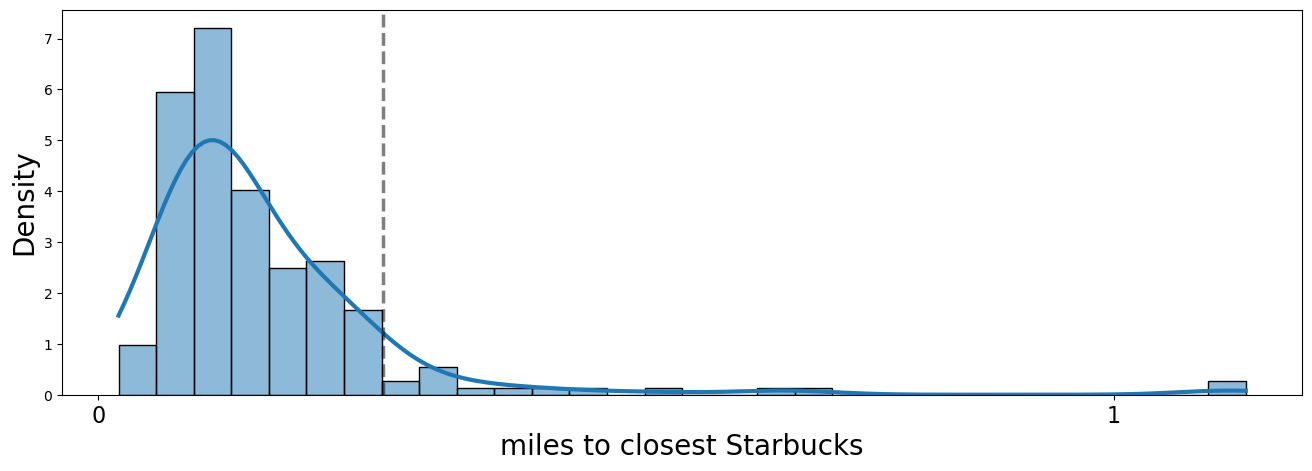

In [27]:
plt.figure(figsize=(16,5))
sns.histplot(closest_dists_lim, kde=True, line_kws={'linewidth': 3}, stat='density')
plt.xlabel('miles to closest Starbucks', fontsize=20)
plt.xticks(np.arange(0, 1.5), fontsize=16)
plt.ylabel('Density', fontsize=20)
plt.axvline(np.mean(closestDists), color='k', linestyle='--', linewidth=2.5, alpha=0.5)